# Analysis of output files
## Prepare environment, functions etc.

In [1]:
import os
import sys
import pandas
import matplotlib
import numpy
from algorithm_tester.helpers import FilePair

# Zapnout zobrazování grafů (procento uvozuje „magickou” zkratku IPythonu):
%matplotlib inline

path = 'tester_results'
solutions = '../data'

In [2]:
#pandas.set_option('display.max_rows', None)
#pandas.read_csv?

## Important functions

In [3]:
def get_file_paths_from_dir(path: str, include_sol: bool = False, include_instance: bool = True) -> (str, str):
    dataset_prefix: str = path.split("/")[-1]
    for root, _, files in os.walk(path):
        dataset: str = dataset_prefix + "_" + "_".join(root.replace(path, "")[1:].split('/'))
        for file in files:
            if "column" not in file:
                if ("_sol" in file and include_sol) or ("_inst" in file and include_instance):
                    yield (dataset, f'{root}/{file}')

def get_cols_list(path: str):
    cols = pandas.read_csv(path, index_col=None, delimiter=" ", header=None)
    return list(cols.iloc[0])

def load_sol_from_dir(folder_path: str, column_list):
    """ Load solutions from directory files into table. """
    it = get_file_paths_from_dir(folder_path, include_sol=True, include_instance=False)
    output_table = None
        
    for (dataset, filepath) in it:
        curr_table = pandas.read_csv(filepath, index_col=None, delimiter=" ", header=None).iloc[:,0:3]
        curr_table.columns = column_list
        curr_table["dataset"] = dataset
                
        if output_table is not None:
            output_table = output_table.append(curr_table, ignore_index=True)
        else:
            output_table = curr_table
    
    return output_table

def load_data_from_dir(folder_path: str, column_list):
    """ Load data from directory files into table. """
    it = get_file_paths_from_dir(folder_path)
    output_table = None
    
    for (dataset, filepath) in it:
        curr_table = pandas.read_csv(filepath, index_col=None, delimiter=" ", header=None)
        curr_table.columns = column_list
        curr_table["dataset"] = dataset
                
        if output_table is not None:
            output_table = output_table.append(curr_table, ignore_index=True)
        else:
            output_table = curr_table
    
    #output_table = output_table.set_index(['algorithm', 'dataset', 'id', "item_count"])
    #output_table.sort_values(by=["algorithm", "dataset", "item_count", "id"], inplace=True)
    return output_table

def construct_table_from(filePair: FilePair):
    solution_table = pandas.read_csv(filePair.solutionFile, header=None, index_col=None, delimiter=" ")
    data_table = pandas.read_csv(filePair.dataFile, header=None, index_col=None, delimiter=" ")
    
    item_count = data_table.iloc[0, 1]
    
    solution_table = solution_table.drop_duplicates(subset=[0], keep='first').reset_index()

    data_table = data_table.iloc[:, 4:]
    data_table = data_table[data_table.columns[::2]]

    info_table = pandas.concat([solution_table.iloc[:, 1], solution_table.iloc[:, 3], data_table.max(axis=1)], axis=1)
    info_table.columns = ["id", "best_value", "max_cost"]
    info_table["item_count"] = item_count
    return info_table

def create_avg_time_table(table, name: str, column_name: str = "item_count"):
    # Create a table of average times according to algorithm and item_count columns
    avg_times = table.groupby(["algorithm_name", column_name])['elapsed_time'] \
        .mean().reset_index().set_index(["algorithm_name", column_name])
    avg_times = avg_times.round(2)

    # Move all values of algorithm column into separate columns
    avg_times = avg_times.unstack("algorithm_name")
    avg_times.columns = avg_times.columns.droplevel()
    avg_times.name = f"Avg #configs per {column_name}"
    avg_times.sort_values(by=column_name, inplace=True)
    #avg_times.fillna("-", inplace=True)

    # Save the dataframe to csv
    #avg_times.to_excel(f'excel/{name}_avg_times.xlsx', sheet_name=name)
    
    return avg_times

def create_avg_error_table(table, column_name: str):
    table["relative_error"] = numpy.abs(table["best_value"] - table["found_value"])/table["best_value"]
    table = table.fillna(0)
    
    error_group = table.groupby([column_name, "algorithm_name"])["relative_error"]

    error_max = error_group.max().reset_index() \
        .rename(columns={'relative_error':'max_relative_error'})
    error_avg = error_group.mean().reset_index() \
        .rename(columns={'relative_error':'avg_relative_error'})
    
    # Construct, unstack
    avg_error = pandas.merge(error_max, error_avg, on=[column_name, "algorithm_name"])
    #avg_error = error_max.join(error_avg).round(6)
    #avg_error.columns = ["max_relative_error", "avg_relative_error"]
    avg_error.name = f"Avg & max relative error per "

    #avg_error.to_excel(f"excel/{name}_avg_error.xlsx", sheet_name=name)
    
    return avg_error

In [4]:
# Create column lists

sol_cols = ["id", "item_count", "best_value"]
cols = get_cols_list(f'{path}/column_description.dat')

## Put data from all analysis files into tables

In [5]:
# Load tables of all strategies
#balance_table = load_data_from_dir(f'{path}/Balance', cols) \
#    .rename(columns={'instance_info':'balance'})
#robust_table = load_data_from_dir(f'{path}/Robust', cols) \
#    .drop(columns="instance_info")

nk_table = load_data_from_dir(f'{path}/NK', cols) \
    .drop(columns="things") \
    .merge(load_sol_from_dir(f'{solutions}/NK', sol_cols).drop(columns="dataset"), on=["id", "item_count"])
zkc_table = load_data_from_dir(f'{path}/ZKC', cols) \
    .drop(columns="things") \
    .merge(load_sol_from_dir(f'{solutions}/ZKC', sol_cols).drop(columns="dataset"), on=["id", "item_count"])
zkw_table = load_data_from_dir(f'{path}/ZKW', cols) \
    .drop(columns="things") \
    .merge(load_sol_from_dir(f'{solutions}/ZKW', sol_cols).drop(columns="dataset"), on=["id", "item_count"])
nk_table

,id,item_count,algorithm_name,init_temperature,cooling,min_temperature,cycles,found_value,elapsed_configs,elapsed_time,dataset,best_value
0,1,40,SA,1000.0,0.995,1.0,50,36583,68950,354.030617,NK_,38667
1,1,40,SAPenalty,1000.0,0.995,1.0,50,22817,68950,400.976691,NK_,38667
2,2,40,SA,1000.0,0.995,1.0,50,28611,68950,584.387324,NK_,28802
3,2,40,SAPenalty,1000.0,0.995,1.0,50,17713,68950,392.843786,NK_,28802
4,3,40,SA,1000.0,0.995,1.0,50,41155,68950,393.383550,NK_,43501
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,498,30,SA,1000.0,0.995,1.0,50,38957,68950,341.111273,NK_,39283
4996,499,30,SAPenalty,1000.0,0.995,1.0,50,9183,68950,390.139960,NK_,14416
4997,499,30,SA,1000.0,0.995,1.0,50,14416,68950,647.209041,NK_,14416
4998,500,30,SAPenalty,1000.0,0.995,1.0,50,7142,68950,393.274741,NK_,14262


# Parameter analysis

In [6]:
param_sols = load_sol_from_dir(f'{solutions}/ParamAnalysis', sol_cols) \
    .drop(columns="dataset")

init_temp_table = load_data_from_dir(f'{path}/ParamAnalysis/InitTemperature', cols) \
    .drop(columns=["things", "cycles", "min_temperature", "cooling"]) \
    .merge(param_sols, on=["id", "item_count"])
init_temp_table["init_temp"] = init_temp_table["dataset"]\
    .str.split("_", n = 1, expand = True)[1].astype(int)

cooling_table = load_data_from_dir(f'{path}/ParamAnalysis/Cooling', cols) \
    .drop(columns=["things", "cycles", "min_temperature", "init_temperature"]) \
    .merge(param_sols, on=["id", "item_count"])
cooling_table["cooling_coef"] = cooling_table["dataset"]\
    .str.split("_", n = 1, expand = True)[1].astype(int)

cycles_table = load_data_from_dir(f'{path}/ParamAnalysis/Cycles', cols) \
    .drop(columns=["things", "init_temperature", "min_temperature", "cooling"]) \
    .merge(param_sols, on=["id", "item_count"])
cycles_table["cycles"] = cycles_table["dataset"]\
    .str.split("_", n = 1, expand = True)[1].astype(int)

cycles_table


,id,item_count,algorithm_name,cycles,found_value,elapsed_configs,elapsed_time,dataset,best_value
0,1,32,SA,50,32941,62000,45.145702,Cycles_50,32944
1,1,32,SA_OLD,50,30302,62000,312.735064,Cycles_50,32944
2,1,32,SAPenalty,50,19511,62000,362.063035,Cycles_50,32944
3,1,32,SA,150,32941,186000,149.657889,Cycles_150,32944
4,1,32,SA_OLD,150,31683,186000,942.291557,Cycles_150,32944
...,...,...,...,...,...,...,...,...,...
18130,500,35,SA,100,29457,124000,97.378758,Cycles_100,29684
18131,500,35,SA_OLD,100,29339,124000,668.665596,Cycles_100,29684
18132,500,35,SAPenalty,200,14421,248000,1429.187039,Cycles_200,29684
18133,500,35,SA,200,29457,248000,220.829198,Cycles_200,29684


In [7]:
error_init_temp = create_avg_error_table(init_temp_table, "init_temp")
error_cooling = create_avg_error_table(cooling_table, "cooling_coef")
error_cycles = create_avg_error_table(cycles_table, "cycles")

time_init_temp = create_avg_time_table(init_temp_table, name="initial temperature", column_name="init_temp")
time_cooling = create_avg_time_table(cooling_table, name="cooling coefficient", column_name="cooling_coef")
time_cycles = create_avg_time_table(cycles_table, name="number of cycles", column_name="cycles")


In [8]:
error_init_temp.query('algorithm_name == "SAPenalty" or algorithm_name == "SA"')\
    .set_index(["init_temp", "algorithm_name"]).unstack("algorithm_name")


max_relative_error           avg_relative_error          
algorithm_name                 SA SAPenalty                 SA SAPenalty
init_temp                                                               
100                      0.598615  0.767103           0.017867  0.429180
300                      0.598615  0.767103           0.012245  0.428923
500                      0.598615  0.767103           0.011739  0.429593
700                      0.262642  0.835176           0.009464  0.431327
900                      0.262642  0.835176           0.009193  0.433029
1000                     0.238636  0.835176           0.008800  0.433757
2500                     0.262642  0.909091           0.009483  0.438468

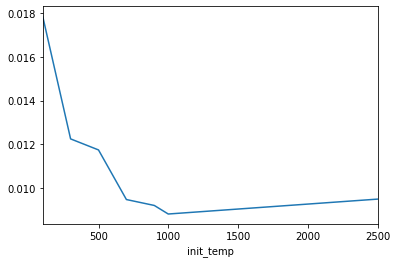

In [9]:
error_init_temp.query('algorithm_name == "SA"').set_index("init_temp").loc[:, "avg_relative_error"].plot()

## DataAnalysis

In [12]:
dpath = f'{path}/DataAnalysis'
dsolutions = f'{solutions}/DataAnalysis'

balance_table = load_data_from_dir(f'{dpath}/Balance', cols) \
    .rename(columns={'instance_info':'balance'})\
    .merge(load_sol_from_dir(f'{dsolutions}/Balance', sol_cols).drop(columns="dataset"), on=["id", "item_count"])
correlation_table = load_data_from_dir(f'{dpath}/Correlation', cols) \
    .rename(columns={'instance_info':'correlation'})
granularity_heavy_table = load_data_from_dir(f'{dpath}/GranularityHeavy', cols) \
    .rename(columns={'instance_info':'constant'})
granularity_light_table = load_data_from_dir(f'{dpath}/GranularityLight', cols) \
    .rename(columns={'instance_info':'constant'})
maxcost_table = load_data_from_dir(f'{dpath}/MaxCost', cols) \
    .rename(columns={'instance_info':'maxcost'})
maxweight_table = load_data_from_dir(f'{dpath}/MaxWeight', cols) \
    .rename(columns={'instance_info':'maxweight'})
things_table = load_data_from_dir(f'{dpath}/Things', cols)
weight_cap_ratio_table = load_data_from_dir(f'{dpath}/WeightCapRation', cols) \
    .rename(columns={'instance_info':'ratio'})

In [19]:
load_sol_from_dir(f'{solutions}/Balance', sol_cols)

,id,item_count,best_value,dataset
0,1,35,11633,NK_
1,2,35,28067,NK_
2,3,35,37706,NK_
3,4,35,40229,NK_
4,5,35,21486,NK_
...,...,...,...,...
2495,496,30,14950,NK_
2496,497,30,13240,NK_
2497,498,30,39283,NK_
2498,499,30,14416,NK_
